In [518]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import pandas as pd


### **Question1**

In [519]:
#Non-linear functions
def sigmoid(x):
    return 1/(1+np.exp(-x))

def tanh(x):
    return np.tanh(x)

def ReLU(x):
    return np.maximum(0,x)

def PReLU(x, alpha):
  if(x>0):
    y=x
  else:
    y=alpha*x
  return y

def softmax(z):
  return z/np.sum(z)


In [520]:
def padded_ref_img(img, p_h, p_w):

  w,h = img.shape

  p_1 = math.ceil(p_h/2)
  p_2 = math.ceil(p_w/2)

  a = np.zeros((w+2*p_1, h+2*p_2))

  for i in range(w):
    for j in range(h):
      a[p_1+j, p_2+i] = img[j, i]

  for i in range(p_2):
    for j in range(h):
      a[p_1+j, p_2-i-1] = a[p_1+j, p_2+i]
      a[p_1+j, w+p_2+i] = a[p_1+j, w+p_2-1-i]

    for i in range(p_1):
        a[p_1-1-i] = a[p_1+i]
        a[h+p_1+i] = a[h+p_1-1-i]
    
    if(p_h%2 != 0): 
      a = a[1:]
    if(p_w%2 != 0):
      a = (a.T[1:]).T
    return a

Convolution function

In [521]:
def conv(img, kernel, s, p, act_f):
    w, h, c = img.shape
    k, k, c = kernel.shape
    J = np.zeros((((w-k)//s + 1),((h-k)//s + 1)))

    if(p == True): 
        p_w = w*(s-1)-s+k
        p_h = h*(s-1)-s+k
      
        padded_img = np.zeros((w+p_w,h+p_h,c))
        for i in range(c):
            padded_img[:,:,i] = padded_ref_img(img[:,:,i],p_h,p_w)

        J = np.zeros((w,h))
        img = padded_img
        w, h, c = img.shape
        J = np.zeros((((w-k)//s + 1),((h-k)//s + 1)))

    flip_ker = np.zeros(kernel.shape)
    for i in range(k):
      for j in range(k):
          for C in range(c):
            flip_ker[i, j, C] = kernel[k-1-i, k-1-j, C]

    kernel = flip_ker

    for z in range(c):
      for x in range(J.shape[0]):
          for y in range(J.shape[1]):
              tem = img[x*s:x*s+k, y*s:y*s+k, z]
              J[x, y] += np.sum(np.multiply(kernel[:,:,z],tem))

    if(act_f == 'sigmoid'):
        J = sigmoid(J)
      
    elif(act_f == 'tanh'):  
        J = tanh(J)

    elif(act_f == 'ReLU'):  
        J = ReLU(J) 

    elif(act_f == 'PReLU'):
        J[x, y] = PReLU(J[x, y], 0.01)

    return J

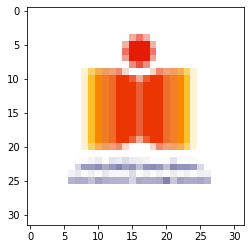

In [522]:
#Input of image
img = mpimg.imread('logo.png')
plt.imshow(img)

[[[0.52533434 0.63314797 0.0542841 ]
  [0.58535249 0.0720801  0.61190015]
  [0.76033001 0.37758338 0.3576974 ]]

 [[0.48189278 0.43549467 0.88111391]
  [0.3460718  0.46781687 0.68265633]
  [0.58566841 0.56158774 0.46098639]]

 [[0.95280508 0.00377489 0.84695168]
  [0.20556967 0.95954011 0.56038674]
  [0.41681501 0.14569407 0.86963633]]]


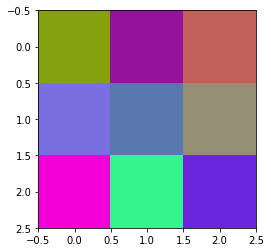

In [523]:
# Kernel 
kernel = np.random.rand(3,3,3)
print(kernel)
plt.imshow(kernel)

(32, 32)


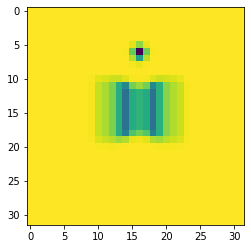

In [524]:
# Output activation map with padding 
conv_img = conv(img, kernel, s=1, p=True, act_f='sigmoid')
plt.imshow(conv_img)
print(conv_img.shape)

(30, 30)


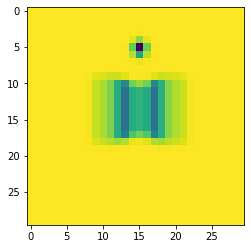

In [525]:
# Output activation map without padding
conv_img = conv(img, kernel, s=1, p=False, act_f='sigmoid')
plt.imshow(conv_img)
print(conv_img.shape)

## **Question2**

Pooling function

In [526]:
def pooling_f(act_map,pooling,s,p):
    w,h = act_map.shape
    pooled_output = []
    for i in range(0,w,s):
      out_row = []
      for j in range(0,h,s):  
          X = act_map[i:i+p[0]-1,j:j+p[1]-1]
          X = np.matrix(X)

          if(pooling.lower()=='max'):
            out_row.append(X.max())
          elif(pooling.lower()=='average'):
            out_row.append(X.sum()/(p[0]*p[1]))
          elif(pooling.lower()=='min'):
            out_row.append(X.min())  
          
      pooled_output.append(out_row)
      
    Img_pooled = np.matrix(pooled_output)
    return Img_pooled


(30, 30)


Text(0.5, 1.0, 'Input activation map')

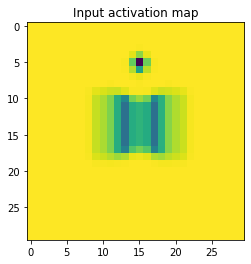

In [527]:
print(conv_img.shape)
plt.imshow(conv_img)
plt.title("Input activation map")

(15, 15)


Text(0.5, 1.0, 'output activation map')

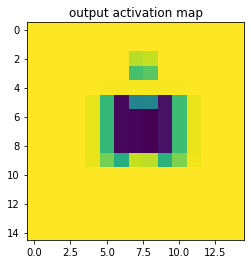

In [528]:
pooled_actmap = pooling_f(conv_img, 'max', 2, [2,2])
print(pooled_actmap.shape)
plt.imshow(pooled_actmap)
plt.title("output activation map")

## **Question3**

Convolutional layer function

Image shape = (32, 32, 4)


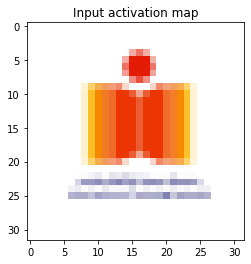

In [529]:
def convolution_layer(img,k_num,k_size,s,p,act_f):
    if(img.ndim == 2):
      img = np.array(img)
      img = img.reshape((img.shape[0], img.shape[1], 1))

    c = img.shape[2]
    out_actmaps = []
    for m in range(k_num):
        kernl = np.random.random((k_size[0],k_size[1],c))
        outmap_m = conv(img,kernel,s,p,act_f)
        out_actmaps.append(outmap_m)
  
    out_actmaps = np.array(out_actmaps)
    out_actmaps = out_actmaps.transpose(1,2,0)

    return out_actmaps

num_k = 2
act_vol = convolution_layer(img,num_k,[3,3],1,True,ReLU)

plt.imshow(img)
plt.title("Input activation map")

print('Image shape =',img.shape)


Output activation map volume shape = (32, 32, 2)


Text(0.5, 1.0, 'Output activation map')

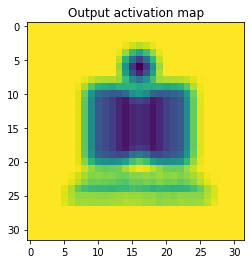

In [530]:
print('Output activation map volume shape =', act_vol.shape)
for i in range(num_k):
  plt.imshow(act_vol[:,:,i])
plt.title('Output activation map')

# **Question4**

Pooling layer function

Text(0.5, 1.0, 'Input activation volume')

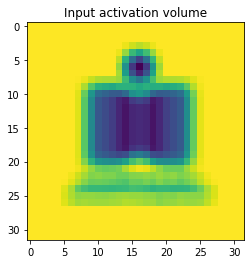

In [531]:
def pooling_layer(map_vol,pooling,s,p):
    pooled_out_vol = []
    for i in range(map_vol.shape[2]):
        pooled_out_vol.append(pooling_f(map_vol[:,:,i],pooling,s,p))

    pooled_out_vol = np.array(pooled_out_vol)
    pooled_out_vol = pooled_out_vol.transpose(1,2,0)
    return pooled_out_vol

pooled_act_vol = pooling_layer(act_vol,'max',3,[4,4])

m = act_vol.shape[2]

for i in range(m):
  plt.imshow(act_vol[:,:,i])
plt.title('Input activation volume')

    

Text(0.5, 1.0, 'Pooled output activation volume')

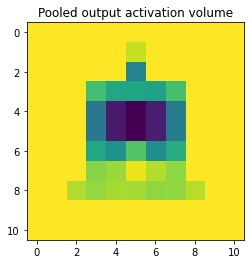

In [532]:
for i in range(m):
  plt.imshow(pooled_act_vol[:,:,i])
plt.title('Pooled output activation volume')

# **Question5**

Flattening function

In [533]:
def flattening(img, m):
    w, h, c = img.shape
    img = img.T.reshape((w*h*c))
    w_matrix = np.random.rand(m,w*h*c)
    return w_matrix@img

flattened_vec = flattening(pooled_act_vol,100)
print('Shape of flattened output vector',flattened_vec.shape)

Shape of flattened output vector (100,)


# **Question6**

Multilayered perceptron function

In [534]:
def hidlayer_output(in_vec, k, act_f):
    l = len(in_vec) + 1
    initial_w = np.random.rand(l,k)
    x = np.ones(l)
    x[1:] = in_vec
    z = x@initial_w

    if(act_f == 'sigmoid'): 
      return sigmoid(z)
    elif(act_f == 'tanh'): 
      return tanh(z)
    elif(act_f == 'ReLU'): 
      return np.array([ReLU(i) for i in z])
    elif(act_f == 'PReLU'): 
      return np.array([PReLU(i) for i in z])
    return z

In [535]:
#Softmax function
def softmax(vec):
  exp_sum = 0
  for i in vec:
    exp_sum += np.exp(i)
  softmax = np.array([(np.exp(i)/exp_sum) for i in vec])
  return softmax

In [536]:
def MLP(in_vec, num_hidlayers, size_hidlayers, act_f, size_outlayer):
    x = in_vec
    for k in size_hidlayers:
        x = hidlayer_output(x,k,act_f)
    
    initial_w = np.random.rand(size_hidlayers[num_hidlayers-1]+1,size_outlayer)
    t = np.ones(size_hidlayers[num_hidlayers-1]+1)
    t[1:] = x
    z = t@initial_w

    y = softmax(z)
    return y,z

## **Question7**

Feed-forward path

In [537]:
def ffp(img):
    c1 = convolution_layer(img, k_num=16, k_size=[3,3,3], s=1, p=False, act_f='sigmoid')
    p1 = pooling_layer(c1, pooling='max', s=2, p=[2,2])
    c2 = convolution_layer(p1, k_num=8, k_size=[3,3,16], s=1, p=False, act_f='sigmoid')
    p2 = pooling_layer(c2, pooling='max', s=2, p=[2,2])
    MLP_input = flattening(p2, 5)
    with_softmax, without_softmax = MLP(MLP_input,1,[15], act_f='sigmoid', size_outlayer=10)
    return with_softmax, without_softmax

In [538]:
img = mpimg.imread('logo.png')

In [539]:
c1 = convolution_layer(img, k_num=16, k_size=[3,3,3], s=1, p=False, act_f='sigmoid')
print(c1.shape)

(30, 30, 16)


In [540]:
p1 = pooling_layer(c1,pooling='max',s=2, p=[2,2])
print(p1.shape)

(15, 15, 16)


In [541]:
c2 = convolution_layer(p1, k_num=8, k_size=[3,3,16], s=1, p=False, act_f='sigmoid')
print(c2.shape)

(13, 13, 8)


In [542]:
p2 = pooling_layer(c2,pooling='max',s=2, p=[2,2])
print(p2.shape)

(7, 7, 8)


In [543]:
MLP_input = flattening(p2, 5)
print(MLP_input.shape)

(5,)


In [544]:
with_softmax, without_softmax = MLP(MLP_input,1,[13],act_f='sigmoid',size_outlayer=10)
print(with_softmax)
print(without_softmax)


[0.35469775 0.05111635 0.27167349 0.02378601 0.01607993 0.02102958
 0.05658031 0.16868662 0.02040981 0.01594013]
[8.86781662 6.9306551  8.60115154 6.16564806 5.77412279 6.04248075
 7.03221159 8.12459329 6.01256622 5.76539054]


# **Question8(a)**

In [545]:
imgs = []
imgs.append(mpimg.imread('airplane1.png'))
imgs.append(mpimg.imread('automobile1.png'))
imgs.append(mpimg.imread('bird1.png'))
imgs.append(mpimg.imread('cat1.png'))
imgs.append(mpimg.imread('deer1.png'))
imgs.append(mpimg.imread('dog1.png'))
imgs.append(mpimg.imread('frog1.png'))
imgs.append(mpimg.imread('horse1.png'))
imgs.append(mpimg.imread('ship1.png'))
imgs.append(mpimg.imread('truck1.png'))

In [546]:
for i in imgs:
  softmax_output = ffp(i)[1]
  print(softmax_output)

[7.88982577 6.61801937 8.820455   9.48822053 9.52694913 8.24379349
 9.35415423 8.25369409 9.38196822 8.77431289]
[5.99279126 8.88836052 7.73508585 8.54835147 7.2154974  9.01256214
 9.28463603 9.26263225 7.59703144 8.6777793 ]
[8.33622657 7.13001826 7.73906419 7.36923062 8.23161952 6.64128408
 7.86685988 6.77720823 8.31761575 7.91414392]
[6.32374776 9.5147777  8.48023466 6.68966609 8.58305888 9.37696662
 5.69350516 9.1119794  6.63395054 9.01985744]
[8.43473074 7.97447017 8.63307182 7.76743534 9.0709268  8.06605041
 7.00050988 8.08209946 7.79877513 7.99132673]
[7.49448086 8.12452714 7.02365823 9.22996723 8.04897743 9.78053717
 6.97175752 8.08082237 8.5780064  6.57926713]
[7.85758818 8.31940161 9.11816182 7.73956279 9.76071308 7.83179213
 7.27714725 7.89148314 8.1645528  9.32445163]
[ 7.10520549  9.0687665   7.98299885 10.96908007  7.92769543  8.1365051
  7.91526078  5.76307575 11.56040348  8.52279533]
[7.53360752 8.00636555 6.38875773 8.10766469 5.15841448 5.9482191
 7.43884918 8.1581234

Some elements of the softmax output vectors are nearly the same and in few one element is comparetively larger than the others. 

# **Question8**(b)

Bottleneck layer

In [547]:
def bottleneck(img):
    c1 = convolution_layer(img, k_num=16, k_size=[3,3,3], s=1, p=False, act_f='sigmoid')
    p1 = pooling_layer(c1,pooling='max',s=2, p=[2,2])
    c2 = convolution_layer(p1, k_num=8, k_size=[3,3,16], s=1, p=False, act_f='sigmoid')
    p2 = pooling_layer(c2,pooling='max',s=2, p=[2,2])
    MLP_input = flattening(p2, 5)
    return MLP_input

In [548]:
imgs = []
imgs.append(mpimg.imread('airplane1.png'))
imgs.append(mpimg.imread('automobile1.png'))
imgs.append(mpimg.imread('bird1.png'))
imgs.append(mpimg.imread('cat1.png'))
imgs.append(mpimg.imread('deer1.png'))
imgs.append(mpimg.imread('dog1.png'))
imgs.append(mpimg.imread('frog1.png'))
imgs.append(mpimg.imread('horse1.png'))
imgs.append(mpimg.imread('ship1.png'))
imgs.append(mpimg.imread('truck1.png'))
imgs.append(mpimg.imread('airplane2.png'))
imgs.append(mpimg.imread('automobile2.png'))
imgs.append(mpimg.imread('bird2.png'))
imgs.append(mpimg.imread('cat2.png'))
imgs.append(mpimg.imread('deer2.png'))
imgs.append(mpimg.imread('dog2.png'))
imgs.append(mpimg.imread('frog2.png'))
imgs.append(mpimg.imread('horse2.png'))
imgs.append(mpimg.imread('ship2.png'))
imgs.append(mpimg.imread('truck2.png'))
imgs.append(mpimg.imread('airplane3.png'))
imgs.append(mpimg.imread('automobile3.png'))
imgs.append(mpimg.imread('bird3.png'))
imgs.append(mpimg.imread('cat3.png'))
imgs.append(mpimg.imread('deer3.png'))
imgs.append(mpimg.imread('dog3.png'))
imgs.append(mpimg.imread('frog3.png'))
imgs.append(mpimg.imread('horse3.png'))
imgs.append(mpimg.imread('ship3.png'))
imgs.append(mpimg.imread('truck3.png'))

In [549]:
#Bottleneck layers for three images from each class
X = np.zeros((30,5))
j = 0
for i in imgs:
  X[j] = bottleneck(i)
  j = j+1

In [550]:
# Labeling the images
Y = np.zeros(30)
Y[:10] = range(0,10)
Y[10:20] = range(0,10)
Y[20:] = range(0,10)

In [551]:
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[Text(0.5, 1.0, 'TSNE')]

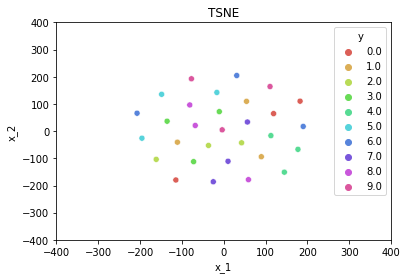

In [552]:
model = TSNE(n_components=2, random_state=0)
tsne = model.fit_transform(X) 

X = pd.DataFrame()
X["x_1"] = tsne[:,0]
X["x_2"] = tsne[:,1]
X["y"] = Y

plt.xlim(-400, 400)
plt.ylim(-400, 400)

sns.scatterplot(data=X, x="x_1", y="x_2", hue=X['y'],
                palette=sns.color_palette("hls", 10)
                ).set(title="TSNE") 


In most of the cases all the same coloured points are nearby and atleast two points of same colours are closer.

Randomly initialized network doesn't distinguish the images of different classes well because of randomisation. Hence, it is non-discriminable.
